## 24h savnet signal recorded on June 26-27 

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import gc
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [4]:
data = "/data/SAVNET/SAVNET_RAW_24h/"

In [5]:
!ls $data

savnet_24h_p1.npy  savnet_24h_p3.npy  savnet_24h_p5.npy
savnet_24h_p2.npy  savnet_24h_p4.npy  structinfo.txt


In [6]:
fnames = ["savnet_24h_p1.npy"]#, "savnet_24h_p2.npy", "savnet_24h_p3.npy", "savnet_24h_p4.npy", "savnet_24h_p5.npy"]

In [7]:
!cat $data/structinfo.txt

        h: <cdata 'struct ADI_FileHandle__ * *' owning 8 bytes>
       id: 2
n_records: 5
  tick_dt: Type::list, Len: 5
  records: Type::list, Len: 5
     name: Channel 2
    units: Type::list, Len: 5
n_samples: [2000001600, 2000001600, 2000001600, 2000001600, 303772800]
       dt: Type::list, Len: 5
       fs: [96000.0, 96000.0, 96000.0, 96000.0, 96000.0]


In [8]:
n_samples= [2000001600, 2000001600, 2000001600, 2000001600, 303772800]
n_test = [1000*96000]
print("signal length=", sum(n_samples), "points")
print("test length=", n_test)

signal length= 8303779200 points
test length= [96000000]


In [9]:
n_samples[0]/96000/3600

5.787041666666666

### Converting 10 min to .wav

In [10]:
n_10min = 96000*600

In [11]:
x = np.load(data+fnames[0])

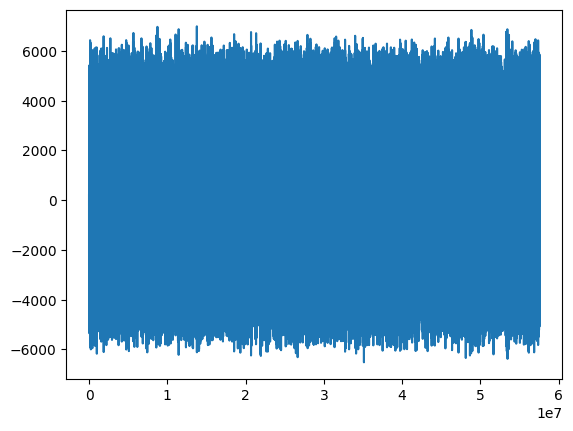

In [10]:
plt.plot(x[:n_10min])

In [13]:
sp.io.wavfile.write("savnet_plo_10min.wav", int(fs), x[:n_10min])

In [12]:
fs = 96e3
sps = int(fs)
dt = 1/fs

fft_npts = 2**12

In [13]:
print("frequency resolution: ", fs/fft_npts, "Hz")

frequency resolution:  23.4375 Hz


In [11]:
fft_npts//2

2048

In [1]:
def burst_filt(s, nsigma):
    sigma_ = np.std(s)
    
def butter_filt(s,cutoff, fs, order=5, fc=12e3):
    #return sp.signal.butter(order, cutoff, fs=fs, btype="low", analog=False)
    sos = sp.signal.butter(order, fc, btype='hp', fs=fs, output='sos')
    filtered = sp.signal.sosfilt(sos, s)
    return filtered

def butter_lpf(st, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sp.signal.lfilter(b, a, st)
    return y

def IQ_quadrature(st, fs, fc, integrate=False, of=4):
    t = np.arange(len(st))/fs; L=2*of
    xi = np.cos(2*np.pi*fc*t)*st  
    xq = -np.sin(2*np.pi*fc*t)*st
    Tb = of/fs
    x = 1#abs(np.cos(np.pi*t/(2*Tb)))
    y = 1#abs(np.sin(np.pi*t/(2*Tb)))

    xi = xi*x
    xq = xq*y
    cutoff_f = 100
    xi = butter_lpf(xi, cutoff_f, fs)
    xq = butter_lpf(xq, cutoff_f, fs)
    if integrate:
        int_xi = integrator(xi, L)
        int_xq = integrator(xq, L)
        return int_xi, int_xq
    return xi, xq

def integrator(st, n=None):
    # st 1d, not complex
    # concvulution
    if not n:
        n=len(st)
    return np.convolve(st, np.ones(n))
    
    

In [19]:
f_tx = 24e3
tv = np.arange(len(data.signal))*Ts
#I = data.signal.values * np.cos(2*np.pi*f_tx*tv)
#Q = data.signal.values * np.sin(2*np.pi*f_tx*tv)

In [20]:
def butter_filt(s,cutoff, fs, order=5):
    #return sp.signal.butter(order, cutoff, fs=fs, btype="low", analog=False)
    sos = signal.butter(order, cutoff, btype='lp', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, s)
    return filtered

In [14]:
signal = pd.DataFrame()

IQ =True
f_tx = 24e3 
freq = np.arange(fft_npts)*fs/fft_npts
w = sp.signal.windows.flattop(fft_npts)

In [2]:

s0 = []
lv = []
signal_raw = np.zeros((n_test[0]//sps)*sps)
signal_iq = np.zeros((n_test[0]//sps)*sps,dtype=complex)
fftv = np.zeros((fft_npts,(n_test[0]//sps) ),dtype=complex)
fftv_sr = np.zeros((fft_npts,(n_test[0]//sps) ),dtype=complex)
for k, f in enumerate(fnames):
    n = n_test[k]
    print(f"Loading {f}...", end="> ")
    #x = pd.Series(np.load(data+f))
    res=False
    x = np.load(data+f)
    
    
    print("Processing  ", end =">\n ")
    #print("Adding to df...")
    #signal = pd.concat([signal, x],ignore_index=True)
    s = []
    count = 1
    start , end = 0, sps
    while end<=n:
        print("\t\t{:8d} to {:8d}".format(start, end),end="\r")
        s = x[start: end] if not res else np.concatenate((s, x[start: end-len(s)]))
        signal_raw[start:end] = s
        I = data.signal.values * np.cos(2*np.pi*f_tx*tv)
        Q = data.signal.values * np.sin(2*np.pi*f_tx*tv)
        fftv_sr[:, count-1] = sp.fft.fftshift(sp.fft.fft(s[0:fft_npts]*w))
        if IQ:
            xi, xq = IQ_quadrature(s, fs, f_tx)
            s = xi+1j*xq
            signal_iq[start:end]= s
        
        lv.append(len(s))
        Sxx = sp.fft.fftshift(sp.fft.fft(s[0:fft_npts]*w))#[:int(fft_npts/2)]
        fftv[:, count-1] = Sxx
        start = end
        count +=1
        end = count*sps
        
    s = x[start:]
    res = True if len(s) else False 
      
    print("\n")
del x
gc.collect()

NameError: name 'np' is not defined

In [16]:
del s, Sxx
gc.collect()

0

In [18]:
fxx = sp.fft.fftshift(sp.fft.fftfreq(fft_npts,1/fs))

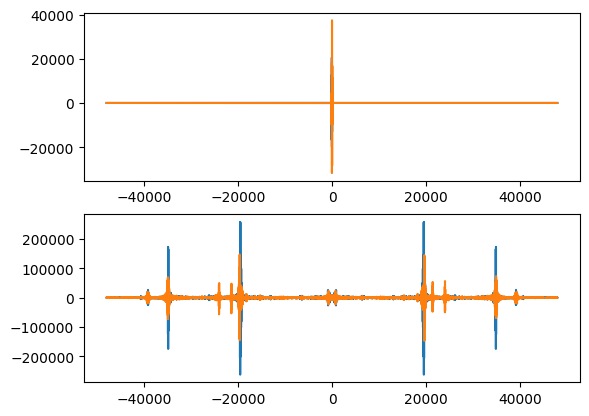

In [21]:
ii=1
plt.subplot(211)
plt.plot(fxx, fftv[:, ii].real)
plt.plot(fxx, fftv[:, ii].imag)
#plt.xlim(-500, 500)

plt.subplot(212)
plt.plot(fxx, fftv_sr[:, ii].real)
plt.plot(fxx, fftv_sr[:, ii].imag)
#plt.xlim(f_tx-500, f_tx+500)
#plt.ylim(-45e3,45e3)

In [30]:
mask0_ii = np.argmin(abs(fxx+200)) 
mask0_ff = np.argmin(abs(fxx-200))
mask24_ii = np.argmin(abs(fxx-(24e3-200))) 
mask24_ff = np.argmin(abs(fxx-(24e3+200)))

In [31]:
fftv_iqtrim = fftv[mask0_ii:mask0_ff, :]
fftv_rtrim = fftv_sr[mask24_ii:mask24_ff, :]

In [ ]:
np.unwrap

In [32]:
phaseiq = np.angle(fftv_iqtrim, deg=True)
phaser = np.angle(fftv_rtrim, deg=True)

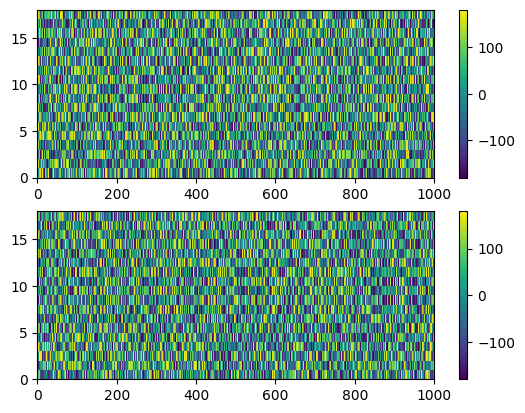

In [34]:
plt.subplot(211)
plt.pcolormesh(phaseiq)
plt.colorbar()
plt.subplot(212)
plt.pcolormesh(phaser)
plt.colorbar()

In [29]:
phaseiq.shape,phaser.shape

((0, 1000), (18, 1000))

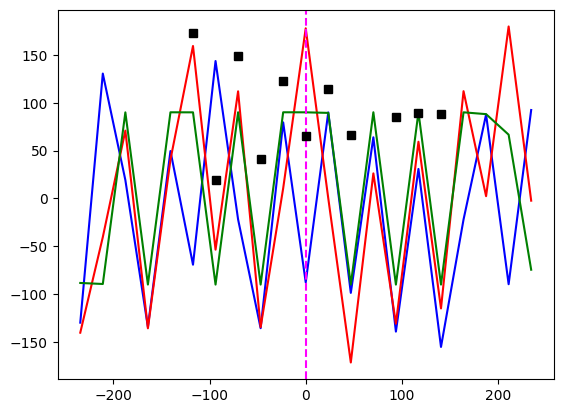

In [31]:
f = 250
k=20
mask = (fxx>=-f) & (fxx<=f)
plt.figure()
ax = plt.gca()
plt.plot(fxx[mask],np.angle(fftv[mask,k], deg=True), color="blue")

#ax2 = ax.twinx()
ax.plot(fxx[mask],np.arctan2(fftv[mask,k].real,fftv[mask,k].imag)*180/np.pi, color="red")
ax.plot(fxx[mask],np.arctan(fftv[mask,k].real,fftv[mask,k].imag)*180/np.pi, color="green")
ax.axvline(0, color="magenta", linestyle="--")

s_=[]
f_ =[] 
for i,a in enumerate(fftv[mask,1]):
    if abs(a)>5000:
        s_.append(a)
        f_.append(fxx[mask][i])
        
ax.plot(f_,abs( np.angle(s_, deg=True)), "sk")

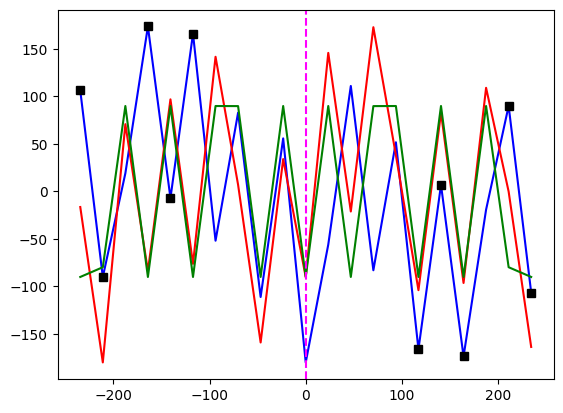

In [35]:
f = 250
k=42
mask = (fxx>=-f) & (fxx<=f)
plt.figure()
ax = plt.gca()
plt.plot(fxx[mask],np.angle(fftv_sr[mask,k], deg=True), color="blue")

#ax2 = ax.twinx()
ax.plot(fxx[mask],np.arctan2(fftv_sr[mask,k].real,fftv_sr[mask,k].imag)*180/np.pi, color="red")
ax.plot(fxx[mask],np.arctan(fftv_sr[mask,k].real,fftv_sr[mask,k].imag)*180/np.pi, color="green")
ax.axvline(0, color="magenta", linestyle="--")

s_=[]
f_ =[] 
for i,a in enumerate(fftv_sr[mask,k]):
    if abs(a)>5000:
        s_.append(a)
        f_.append(fxx[mask][i])
        
ax.plot(f_,( np.angle(s_, deg=True)), "sk")

In [25]:
#spectrogram
ut = True
lupper = 1000
llower = 0
dpi=600
plot_inline =False

fig, ax = plt.subplots(figsize=(24,9))

#props = dict(boxstyle='round', facecolor='wheat', alpha=1)

vmax=80
vmin=40


#cm = ax.pcolormesh(np.asanyarray(timev), freq_wtrim/1000, np.abs(fftv),shading="auto", vmin=0, vmax=vmax )
if ut:
    
    cm = ax.pcolormesh(np.arange(0, fftv.shape[1]), freq, 20*np.log10(np.abs(fftv)/40),vmin=vmin, vmax=vmax )
else:
    cm = ax.pcolormesh(timev, freq_wtrim/1000, np.abs(fftv),shading='nearest',norm=norm_, vmin=0, vmax=0.5)
#cm = ax.pcolormesh(timev1, freq_w, fftv1,vmin=0,vmax=1 )
#ax.set_ylim((10, 50))
if ut:
    ax.set_xlabel("Time (s)")
else:
    ax.set_xlabel("Local Time")
ax.set_ylabel("Frequency (kHz)")
#ax.set_title("Overlap: $w_{size}=%d, p=%.2f $"%(fft_npts_ovlp, povlp/100))

fig.autofmt_xdate()
plt.colorbar(cm, ax=ax, pad=0.01, label="Intensity")
#ax.vlines(185,f0-bw/2,f0+bw/2)
#ax.set_ylim(cutfreq)
#ax.set_xlim((1000,1050))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#ax.set_xlim(datetime.datetime(2023,8,12), datetime.datetime(2023,10,15))
#ax.set_xlim(right =  datetime.datetime(2022,7,2,12))
#ax.set_ylim(top=10)
plt.tight_layout()
fig.savefig(f"savnet_RAW_24htest_{fft_npts}_t_{llower}s-{lupper}s_{dpi}.png", dpi=dpi)
if not plot_inline:
    plt.close()
#plt.grid(which='both', axis='x', linestyle=':')

In [ ]:
plt.tight_layout()
fig.savefig("espectrograma_24h_segundos_4096.png", dpi=300)
plt.close()

In [26]:
del fig, ax
gc.collect()

15

/home/aldo/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


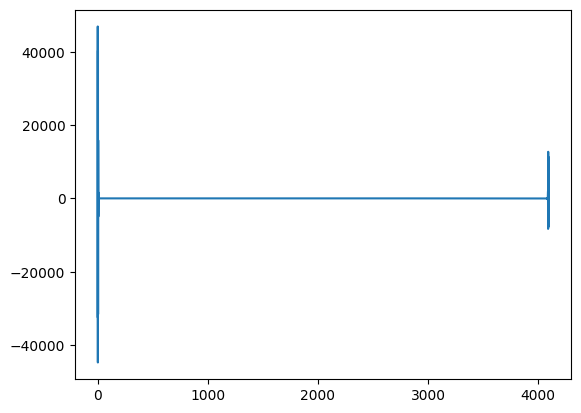

In [18]:
plt.plot(fftv[:,0])

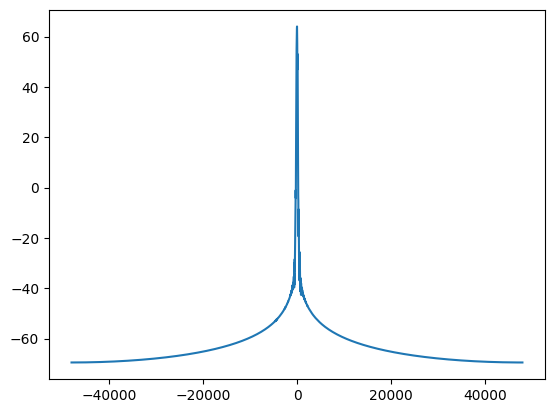

In [29]:
freqc = sp.fft.fftshift(sp.fft.fftfreq(fft_npts, d=1/fs))
plt.plot(freqc, sp.fft.fftshift(20*np.log10(abs(fftv[:,1])/40)))
#plt.xlim(-500, 500)
#plt.xlim(15e3, 30e3)
#plt.plot(freq, abs(fftv[:,1]))
#plt.xlim(15e3, 30e3)

In [23]:
pd.DataFrame(fftv).to_csv("fft.csv")

In [1]:
plt.plot(freqc, 20*np.log10(abs(fftvs[:,4000])/40), )

NameError: name 'plt' is not defined

In [25]:
min(abs(fftv[:,1]))

40.80255035481214

In [119]:
def track_Tx(f_arr,fx, method="fixed", S_arr=None, bw=None):
#f_arr = freq
#fx = 24e3
#bw=200
    if method=="fixed":
        
        index_fx = np.argmin(abs(f_arr-fx))

    elif method=="maxpeak":
        if not S_arr.any(): return None
        bw = 300 if not bw else bw
        i00 = np.argmin(abs(f_arr-(fx-bw/2)))
        iff = np.argmin(abs(f_arr-(fx+bw/2)))
        index_fx = np.argmax(abs(S_arr[i00:iff,:]), axis=0) + i00
    return index_fx

In [142]:
def track_Tx_quadrature_integration(Sxx, fv,bw=200):
    # fv is the freq array centered in 0
    i00 = np.argmin(abs(fv+(bw/2))) # left from 0
    iff = np.argmin(abs(fv-(bw/2))) # right from 0
    #print(fv[i00], fv[iff])
    re = sp.integrate.simpson(Sxx[i00:iff, :].real, fv[i00:iff], axis=0,dx=np.mean(np.diff(fv)))
    im = sp.integrate.simpson(Sxx[i00:iff, :].imag, fv[i00:iff], axis=0,dx=np.mean(np.diff(fv)))
    return re, im

In [108]:
fftvs = sp.fft.fftshift(fftv, axes=0)

In [143]:
ampi = track_Tx_quadrature_integration(fftvs, freqc, 200)

In [2]:
n= 100
plt.plot(freqc, fftvs[:,n].imag)
plt.plot(freqc, fftvs[:,n].real)
plt.axvline(color="red")
plt.xlim(-200,200)

NameError: name 'plt' is not defined

In [1]:
ampi

NameError: name 'ampi' is not defined

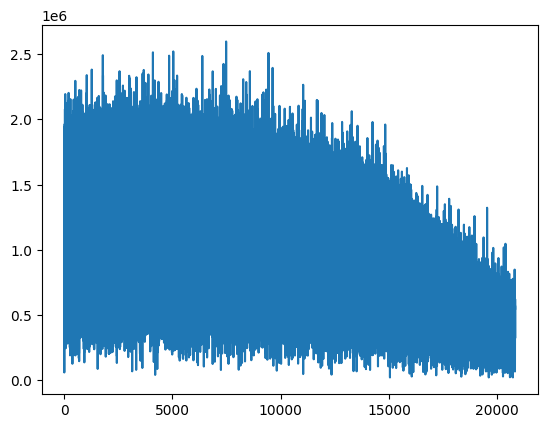

In [146]:
plt.plot(abs(ampi[0]+1j*ampi[1]))

In [79]:
#spectrogram
ut = True
lupper = 1000
llower = 0
dpi=600
plot_inline =False

fig, ax = plt.subplots(figsize=(24,9))

#props = dict(boxstyle='round', facecolor='wheat', alpha=1)

vmax=80
vmin=40


#cm = ax.pcolormesh(np.asanyarray(timev), freq_wtrim/1000, np.abs(fftv),shading="auto", vmin=0, vmax=vmax )
if ut:
    
    cm = ax.pcolormesh(np.arange(0, fftvs.shape[1])[llower:lupper], freqc, 20*np.log10(np.abs(fftvs)/40)[:, llower:lupper],vmin=vmin, vmax=vmax )
else:
    cm = ax.pcolormesh(timev, freq_wtrim/1000, np.abs(fftv),shading='nearest',norm=norm_, vmin=0, vmax=0.5)
#cm = ax.pcolormesh(timev1, freq_w, fftv1,vmin=0,vmax=1 )
#ax.set_ylim((10, 50))
if ut:
    ax.set_xlabel("Time (s)")
else:
    ax.set_xlabel("Local Time")
ax.set_ylabel("Frequency (kHz)")
#ax.set_title("Overlap: $w_{size}=%d, p=%.2f $"%(fft_npts_ovlp, povlp/100))

fig.autofmt_xdate()
plt.colorbar(cm, ax=ax, pad=0.01, label="Intensity")
#ax.vlines(185,f0-bw/2,f0+bw/2)
#ax.set_ylim(cutfreq)
#ax.set_xlim((1000,1050))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#ax.set_xlim(datetime.datetime(2023,8,12), datetime.datetime(2023,10,15))
#ax.set_xlim(right =  datetime.datetime(2022,7,2,12))
#ax.set_ylim(top=10)
plt.tight_layout()
fig.savefig(f"savnet_RAW_24htest_{fft_npts}_t_{llower}s-{lupper}s_{dpi}.png", dpi=dpi)
if not plot_inline:
    plt.close()
#plt.grid(which='both', axis='x', linestyle=':')

In [76]:
ampi


array([0.50854922+0.62252102j, 0.50854922+0.62252102j,
       0.50854922+0.62252102j, ..., 0.50854922+0.62252102j,
       0.50854922+0.62252102j, 0.50854922+0.62252102j])

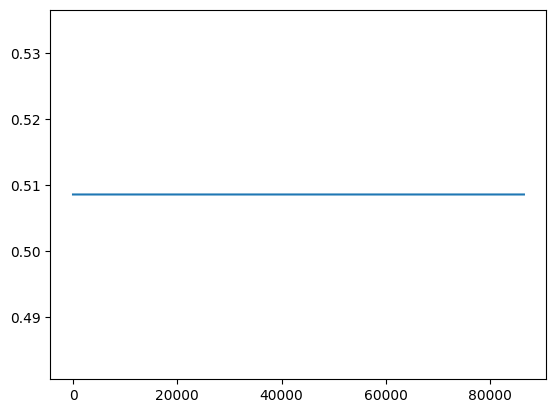

In [77]:
plt.plot(ampi)

In [120]:
ii = track_Tx(freqc,0, method="maxpeak", S_arr=fftvs[:,:],bw=300)


In [93]:
ii

array([1026, 1026, 1024])

(23000.0, 25000.0)

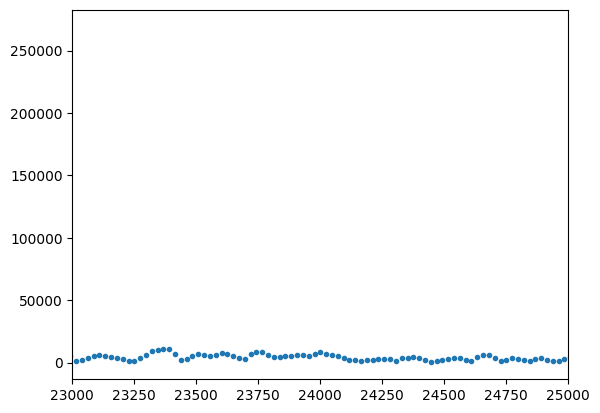

In [120]:
ti=1006*40
#Ax = abs(fftv[index_fx,ti])
#df = []
plt.plot(freq, abs(fftv[:,ti]), '.')
plt.xlim(23e3,25e3)

(23500.0, 24500.0)

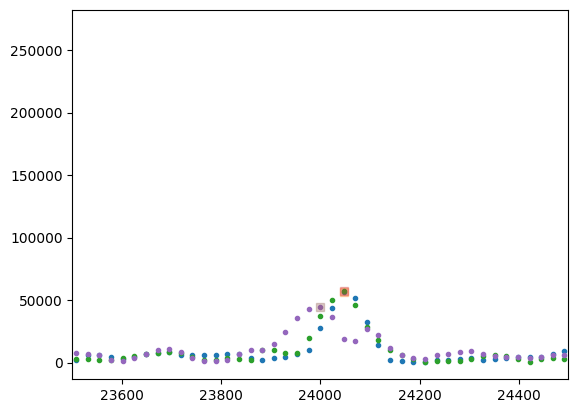

In [115]:
ti=1000*40
Ax = abs(fftv[index_fx,ti])
df = []
#plt.plot(freq, abs(fftv[:,0]), '.')
#plt.plot(freq, abs(fftv[:,1]), '.')
for  i  in [0,1,2]:
    Ax = abs(fftv[ii[i],i])
    plt.plot(freq, abs(fftv[:,i]), '.')
    df.append(freq[ii[i]])
    plt.plot(freq[ii[i]], Ax, "s", alpha=0.3)
plt.xlim(23.5e3,24.5e3)

In [121]:
tracked_index = track_Tx(freqc,0, method="maxpeak", S_arr=fftvs,bw=300)

In [122]:
len(tracked_index)

20833

In [123]:
f_tracked = freq[tracked_index] 
S_tracked = [fftv[i, k] for k,i in enumerate(tracked_index)]

In [124]:
S_tracked = np.asarray(S_tracked)

In [125]:
tt = np.arange(len(f_tracked))
th = 12+tt/3600

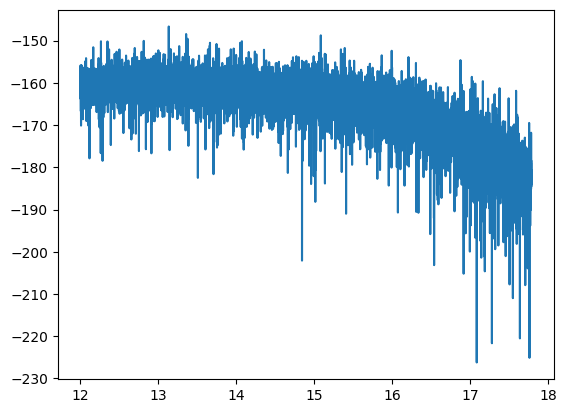

In [126]:
plt.plot(th, 20*np.log(abs(S_tracked)/40))

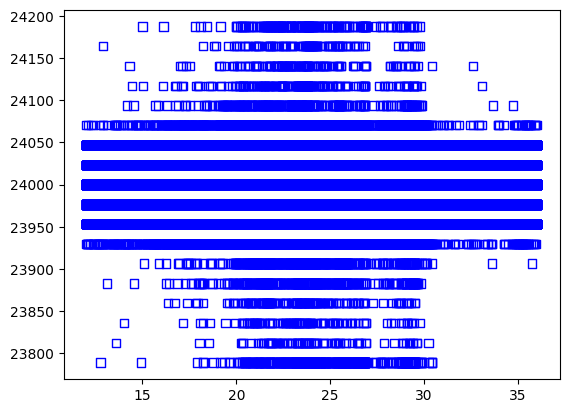

In [122]:
plt.scatter(th, f_tracked,marker="s", facecolors="none", edgecolor="b")
#plt.xlim(0,20)

<StemContainer object of 3 artists>

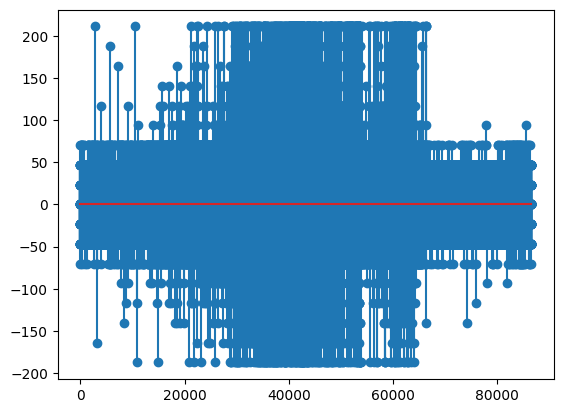

In [114]:
plt.stem(24e3-f_tracked)

In [127]:

day1_f = f_tracked[th<17]
day2_f = f_tracked[th>31]
night_f = f_tracked[(th<=31) & (th>=17)]

(array([  511.,   246.,   677.,  1536., 16974., 20202.,  8389.,  1297.,
          299.,   270.]),
 array([23789.0625 , 23828.90625, 23868.75   , 23908.59375, 23948.4375 ,
        23988.28125, 24028.125  , 24067.96875, 24107.8125 , 24147.65625,
        24187.5    ]),
 <BarContainer object of 10 artists>)

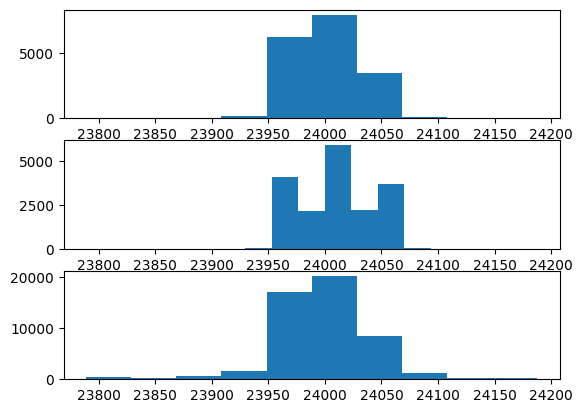

In [128]:
fig = plt.figure()
ax = plt.subplot(311)
plt.hist(day1_f,bins=)
plt.subplot(312, shar20,ex=ax)
plt.hist(day2_f, bins=20)
plt.subplot(313, sharex=ax)
plt.hist(night_f, bins=10)

In [130]:
df = np.diff(f_tracked)

In [131]:
T_tracked = 1/f_tracked

In [132]:
dT = np.diff(T_tracked)

In [133]:
dtheta = 360*24e3*dT

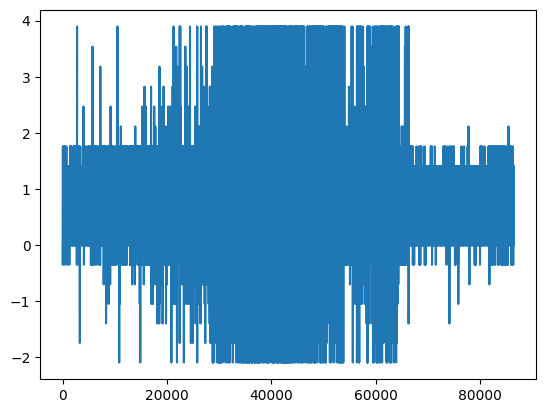

In [135]:
plt.plot(np.cumsum(dtheta))